In [33]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

from fuzzywuzzy import process


# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "correct_return_periods.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths
setup_project_paths(PATH)


#from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data, plot_feature_histograms, plot_contry_period_map
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
from utils_p_i import calculate_p_i
from utils_P_i import calculate_P_i

#from utils_likelihoods import calculate_likelihood_of_at_least_one_event

from utils_return_periods import calculate_return_periods

#from utils_global_probabilities import calculate_global_probabilities
#from utils_country_probabilities import calculate_all_country_probabilities
#from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 

#from utils_country_id_csv_to_json import country_id_csv_to_json

from utils_get_country_names_by_ids import get_country_names_by_ids
from utils_get_country_id_by_name import get_country_id_by_name

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
PATH_RAW_VIEWSER, PATH_RAW_EXTERNAL, PATH_PROCESSED, PATH_GENERATED = get_data_paths(PATH)

In [4]:
# # load the data from pkl
# df_monthly = pd.read_pickle(PATH_RAW_VIEWSER / "simon_full_base_01_viewser_df.pkl")
# 
# df_yearly = aggregate_monthly_to_yearly(df_monthly)
# 
# # Feature engineering
# df_monthly = feature_eng_fat_per_100k(df_monthly)
# df_yearly = feature_eng_fat_per_100k(df_yearly)
# 
# # save the data
# df_monthly.to_pickle(PATH_PROCESSED / "df_monthly_new.pkl")  
# df_yearly.to_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [5]:
# load the data
df_monthly = pd.read_pickle(PATH_PROCESSED / "df_monthly_new.pkl")
df_yearly = pd.read_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [6]:
get_country_id_by_name("Mali")

[(50, 'Mali'), (120, 'Somalia'), (161, 'Malawi')]

In [7]:
def update_df_with_probabilities_and_return_periods_pretest(df, feature):

    # check that it is a pandas dataframe
    if not isinstance(df, pd.DataFrame):
        raise ValueError('df is not a pandas dataframe')

    # check the df is not empty
    if df.empty:
        raise ValueError('DataFrame is empty')

    # checkt that the time period is present
    time_period_column = ['month_id', 'year_id']
    
    if time_period_column[0] not in df.columns and time_period_column[1] not in df.columns:
        raise ValueError('Time period not found')

    # check that the other relevant columns are present
    relevant_columns = ['pg_id', 'c_id', 'row', 'col', feature]
    for column in relevant_columns:
        if column not in df.columns:
            raise ValueError(f'{column} not found in df')

    # check that the feature is not empty
    if df[feature].isnull().all():
        raise ValueError(f'{feature} is empty')

    # check that the feature is not negative
    if (df[feature] < 0).any():
        raise ValueError(f'{feature} contains negative values')

    # check for null, inf and nan
    if df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')

    if np.isinf(df.values).any():
        raise ValueError('DataFrame contains infinite values')

    return True


def get_time_period(df):
    
    if 'month_id' in df.columns:
        return 'month_id'
    
    elif 'year_id' in df.columns:
        return 'year_id'
    
    else:
        print(df.columns)
        #raise ValueError('Time period not found')
    

def check_region_id(region_id_type, region_id, df):

    """
    
    """

    if region_id_type == 'pg_ids':
        # chekc that the region_id is present in the df pg_ids
        if region_id not in df['pg_id'].unique():
            raise ValueError(f'{region_id} not found in pg_id column')
        
    elif region_id_type == 'c_ids':
        # chekc that the region_id is present in the df c_ids
        if region_id not in df['c_id'].unique():
            raise ValueError(f'{region_id} not found in c_id column')
        
    elif region_id_type == 'global':
        pass

    else:
        raise ValueError(f'{region_id_type} not recognized')

    return True

def subset_regional_df(df, region_id_type, region_id):

    """

    """

    if region_id_type == 'pg_ids':
        sub_df = df[df['pg_id'] == region_id].copy()
        
    elif region_id_type == 'c_ids':
        sub_df = df[df['c_id'] == region_id].copy()
        
    elif region_id_type == 'global':
        sub_df = df.copy()

    else:
        raise ValueError(f'{region_id_type} not recognized')
    
    return sub_df

def update_df_with_probabilities_and_return_periods(df, feature, region_id_type, region_id):

    """

    """

    update_df_with_probabilities_and_return_periods_pretest(df, feature)
    check_region_id(region_id_type, region_id, df)
    time_period = get_time_period(df)

    # sub set the df according to the region_id_type and region_id - if global, then the whole df is used but we still do this for consistency
    sub_df = subset_regional_df(df, region_id_type, region_id)


    feature_series = sub_df[feature]
    n_cells = sub_df['pg_id'].unique().shape[0] # THIS WOULD ONLT CHANGE IF WE AGGREGATE THE PRIO GRID CELLS

    # calculate the probabilities and return periods
    df_probabilities = calculate_p_i(feature_series)
    df_probabilities = calculate_P_i(df_probabilities, n_cells)
    df_probabilities = calculate_return_periods(df_probabilities)

    # rename the calculated columns to match the original df feature
    df_probabilities.rename(columns={'value': feature, 'value_count' : f'{feature}_value_count', 'p_i' : f"{feature}_p_i", 'P_i' : f"{feature}_P_i", 'e_i' : f"{feature}_e_i", 'E_i' : f"{feature}_E_i"}, inplace=True)

    # Merge
    merged_df = pd.merge(sub_df, df_probabilities, on=[feature], how='left')

    # check for null, inf and nan
    if merged_df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')

    return merged_df


In [8]:
#contry_id = 50
feature = 'fatalities_per_100k'
region_id_type = 'global' # pg_ids, c_ids, or global
region_id = None

In [9]:
new_df_monthly = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

In [10]:
new_df_yearly.describe()

pg_id        year_id           c_id            col  \
count  458850.000000  458850.000000  458850.000000  458850.000000   
mean   144794.092982    2006.000000     141.969282     407.676506   
std     26708.184196      10.099516      65.657048      36.670957   
min     62356.000000    1989.000000      40.000000     310.000000   
25%    126436.000000    1997.000000      70.000000     383.000000   
50%    149457.500000    2006.000000     157.000000     410.000000   
75%    166012.000000    2015.000000     213.000000     435.000000   
max    190511.000000    2023.000000     246.000000     487.000000   

                 row        sb_best        ns_best        os_best  \
count  458850.000000  458850.000000  458850.000000  458850.000000   
mean      201.536690       0.243844       0.043358       0.060941   
std        37.095851      11.636332       1.786757       1.934838   
min        87.000000       0.000000       0.000000       0.000000   
25%       176.000000       0.000000       0.000000       0.000000   
50%       208.000000       0.000000       0.000000       0.000000   
75%       231.000000       0.000000       0.000000       0.000000   
max       265.000000    3131.000000     645.000000     969.000000   

        pop_gpw_sum     total_best  fatalities_per_100k    sb_per_100k  \
count  4.588500e+05  458850.000000        458850.000000  458850.000000   
mean   1.035208e+06       0.348144             0.039114       0.023447   
std    3.160236e+06      12.696437             1.145011       0.699384   
min    0.000000e+00       0.000000             0.000000       0.000000   
25%    4.229768e+04       0.000000             0.000000       0.000000   
50%    2.637639e+05       0.000000             0.000000       0.000000   
75%    9.264214e+05       0.000000             0.000000       0.000000   
max    1.489921e+08    3221.000000           441.995180     136.282565   

         ns_per_100k    os_per_100k  fatalities_per_100k_value_count  \
count  458850.000000  458850.000000                    458850.000000   
mean        0.008095       0.007572                    424936.963644   
std         0.782681       0.251318                     84066.232054   
min         0.000000       0.000000                         1.000000   
25%         0.000000       0.000000                    441568.000000   
50%         0.000000       0.000000                    441568.000000   
75%         0.000000       0.000000                    441568.000000   
max       441.995180      87.019180                    441568.000000   

       fatalities_per_100k_p_i  fatalities_per_100k_P_i  \
count            458850.000000            458850.000000   
mean                  0.963046                 0.999925   
std                   0.186808                 0.006084   
min                   0.000002                 0.028167   
25%                   1.000000                 1.000000   
50%                   1.000000                 1.000000   
75%                   1.000000                 1.000000   
max                   1.000000                 1.000000   

       fatalities_per_100k_e_i  fatalities_per_100k_E_i  
count            458850.000000            458850.000000  
mean                 11.293104                 1.000316  
std                 868.668673                 0.063541  
min                   1.000000                 1.000000  
25%                   1.000000                 1.000000  
50%                   1.000000                 1.000000  
75%                   1.000000                 1.000000  
max              458850.000000                35.502343

In [11]:
# try with a country
country_name = 'Mali'
country_id = get_country_id_by_name(country_name)
print(country_id)

country_id = 50
region_id_type = 'c_ids' # pg_ids, c_ids, or global

new_df_monthly_mali = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, country_id)
new_df_yearly_mali = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, country_id)

new_df_monthly_mali.describe()
new_df_yearly_mali.describe()

[(50, 'Mali'), (120, 'Somalia'), (161, 'Malawi')]


pg_id       year_id     c_id           col           row  \
count   14910.000000  14910.000000  14910.0  14910.000000  14910.000000   
mean   154573.579812   2006.000000     50.0    353.298122    215.194836   
std      4965.263487     10.099844      0.0      7.440960      6.892226   
min    145064.000000   1989.000000     50.0    337.000000    202.000000   
25%    150823.000000   1997.000000     50.0    349.000000    210.000000   
50%    154436.500000   2006.000000     50.0    353.000000    215.000000   
75%    158045.000000   2015.000000     50.0    359.000000    220.000000   
max    165231.000000   2023.000000     50.0    369.000000    230.000000   

            sb_best       ns_best       os_best   pop_gpw_sum    total_best  \
count  14910.000000  14910.000000  14910.000000  1.491000e+04  14910.000000   
mean       0.080818      0.020322      0.034071  3.669256e+05      0.135211   
std        0.575369      0.248254      0.333146  8.910088e+05      0.916071   
min        0.000000      0.000000      0.000000  3.158785e+03      0.000000   
25%        0.000000      0.000000      0.000000  1.329172e+04      0.000000   
50%        0.000000      0.000000      0.000000  3.074478e+04      0.000000   
75%        0.000000      0.000000      0.000000  4.073543e+05      0.000000   
max       18.000000      9.000000     12.000000  1.665840e+07     25.000000   

       fatalities_per_100k   sb_per_100k   ns_per_100k   os_per_100k  \
count         14910.000000  14910.000000  14910.000000  14910.000000   
mean              0.166606      0.105179      0.029944      0.031483   
std               1.859198      1.326026      0.636969      0.504865   
min               0.000000      0.000000      0.000000      0.000000   
25%               0.000000      0.000000      0.000000      0.000000   
50%               0.000000      0.000000      0.000000      0.000000   
75%               0.000000      0.000000      0.000000      0.000000   
max              65.764693     65.764693     43.346236     27.966811   

       fatalities_per_100k_value_count  fatalities_per_100k_p_i  \
count                     14910.000000             14910.000000   
mean                      13542.959356                 0.954157   
std                        3005.487197                 0.206576   
min                           1.000000                 0.000067   
25%                       14210.000000                 1.000000   
50%                       14210.000000                 1.000000   
75%                       14210.000000                 1.000000   
max                       14210.000000                 1.000000   

       fatalities_per_100k_P_i  fatalities_per_100k_e_i  \
count             14910.000000             14910.000000   
mean                  0.997715                 8.011241   
std                   0.033383               155.745823   
min                   0.028168                 1.000000   
25%                   1.000000                 1.000000   
50%                   1.000000                 1.000000   
75%                   1.000000                 1.000000   
max                   1.000000             14910.000000   

       fatalities_per_100k_E_i  
count             14910.000000  
mean                  1.009555  
std                   0.351117  
min                   1.000000  
25%                   1.000000  
50%                   1.000000  
75%                   1.000000  
max                  35.501207

In [12]:
def plot_features_grid(df, feature, period_range):
    features_list = [feature, f'{feature}_p_i', f'{feature}_P_i', f'{feature}_e_i', f'{feature}_E_i']
    fig, axs = plt.subplots(len(period_range), len(features_list), figsize=(25, 5 * len(period_range)))

    time_peirod = get_time_period(df)

    if time_peirod == 'month_id':
        # check that the range is between 100 and 600 or raise an error
        min_month_id = df['month_id'].min()
        max_month_id = df['month_id'].max()
        if not all(min_month_id <= period <= max_month_id for period in period_range):
            raise ValueError(f'Monthly time period: Period range should be between {min_month_id} and {max_month_id}')
    elif time_peirod == 'year_id':
        # check that the range is between 1980 and 2020 or raise an error'
        min_year_id = df['year_id'].min()
        max_year_id = df['year_id'].max()
        if not all(min_year_id <= period <= max_year_id for period in period_range):
            raise ValueError(f'Yearly time period: Period range should be between {min_year_id} and {max_year_id}')

    for row_idx, period in enumerate(period_range):

        for col_idx, feature_name in enumerate(features_list):

            # Determine colormap and value range
            if 'P_i' in feature_name or 'p_i' in feature_name:
                cmap = 'rainbow_r'
                vmin = 0
                vmax = 1
            else:
                cmap = 'rainbow'
                vmin = df[feature_name].min()
                vmax = df[feature_name].max()

            # Extract the data for the specific month_id
            period_data = df[df[time_peirod] == period]

            # Calculate the grid size based on min and max row and col values
            min_row = int(period_data['row'].min())
            max_row = int(period_data['row'].max())
            min_col = int(period_data['col'].min())
            max_col = int(period_data['col'].max())

            # Create the grid with adjusted size
            grid_rows = max_row - min_row + 1
            grid_cols = max_col - min_col + 1
            grid = np.full((grid_rows, grid_cols), np.nan)

            # Fill the grid with the feature_name values, adjusting for min_row and min_col
            for _, row in period_data.iterrows():
                grid[int(row['row']) - min_row, int(row['col']) - min_col] = row[feature_name]

            # Plot with imshow
            cax = axs[row_idx, col_idx].imshow(grid, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', aspect='auto', interpolation='none')
            fig.colorbar(cax, ax=axs[row_idx, col_idx], orientation='vertical', label=feature_name)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_features_grid(new_df, 'some_feature')

In [13]:
new_df_monthly_mali['month_id'].max()

528

In [14]:
# check wivh month id have the event with the higsest E_i
new_df_monthly_mali[new_df_monthly_mali['fatalities_per_100k_E_i'] == new_df_monthly_mali['fatalities_per_100k_E_i'].max()]['month_id']

117874    385
Name: month_id, dtype: int64

In [15]:
new_df_yearly_mali

pg_id  year_id  c_id  col  row  sb_best  ns_best  os_best  \
0      145064     1989    50  344  202      0.0      0.0      0.0   
1      145064     1990    50  344  202      0.0      0.0      0.0   
2      145064     1991    50  344  202      0.0      0.0      0.0   
3      145064     1992    50  344  202      0.0      0.0      0.0   
4      145064     1993    50  344  202      0.0      0.0      0.0   
...       ...      ...   ...  ...  ...      ...      ...      ...   
14905  165231     2019    50  351  230      0.0      0.0      0.0   
14906  165231     2020    50  351  230      0.0      0.0      0.0   
14907  165231     2021    50  351  230      0.0      0.0      0.0   
14908  165231     2022    50  351  230      0.0      0.0      0.0   
14909  165231     2023    50  351  230      0.0      0.0      0.0   

         pop_gpw_sum  total_best  fatalities_per_100k  sb_per_100k  \
0      499759.312500         0.0                  0.0          0.0   
1      499759.312500         0.0                  0.0          0.0   
2      526924.312500         0.0                  0.0          0.0   
3      554089.312500         0.0                  0.0          0.0   
4      581254.312500         0.0                  0.0          0.0   
...              ...         ...                  ...          ...   
14905   19319.504883         0.0                  0.0          0.0   
14906   19319.504883         0.0                  0.0          0.0   
14907   19319.504883         0.0                  0.0          0.0   
14908   19319.504883         0.0                  0.0          0.0   
14909   19319.504883         0.0                  0.0          0.0   

       ns_per_100k  os_per_100k  fatalities_per_100k_value_count  \
0              0.0          0.0                            14210   
1              0.0          0.0                            14210   
2              0.0          0.0                            14210   
3              0.0          0.0                            14210   
4              0.0          0.0                            14210   
...            ...          ...                              ...   
14905          0.0          0.0                            14210   
14906          0.0          0.0                            14210   
14907          0.0          0.0                            14210   
14908          0.0          0.0                            14210   
14909          0.0          0.0                            14210   

       fatalities_per_100k_p_i  fatalities_per_100k_P_i  \
0                          1.0                      1.0   
1                          1.0                      1.0   
2                          1.0                      1.0   
3                          1.0                      1.0   
4                          1.0                      1.0   
...                        ...                      ...   
14905                      1.0                      1.0   
14906                      1.0                      1.0   
14907                      1.0                      1.0   
14908                      1.0                      1.0   
14909                      1.0                      1.0   

       fatalities_per_100k_e_i  fatalities_per_100k_E_i  
0                          1.0                      1.0  
1                          1.0                      1.0  
2                          1.0                      1.0  
3                          1.0                      1.0  
4                          1.0                      1.0  
...                        ...                      ...  
14905                      1.0                      1.0  
14906                      1.0                      1.0  
14907                      1.0                      1.0  
14908                      1.0                      1.0  
14909                      1.0                      1.0  

[14910 rows x 19 columns]

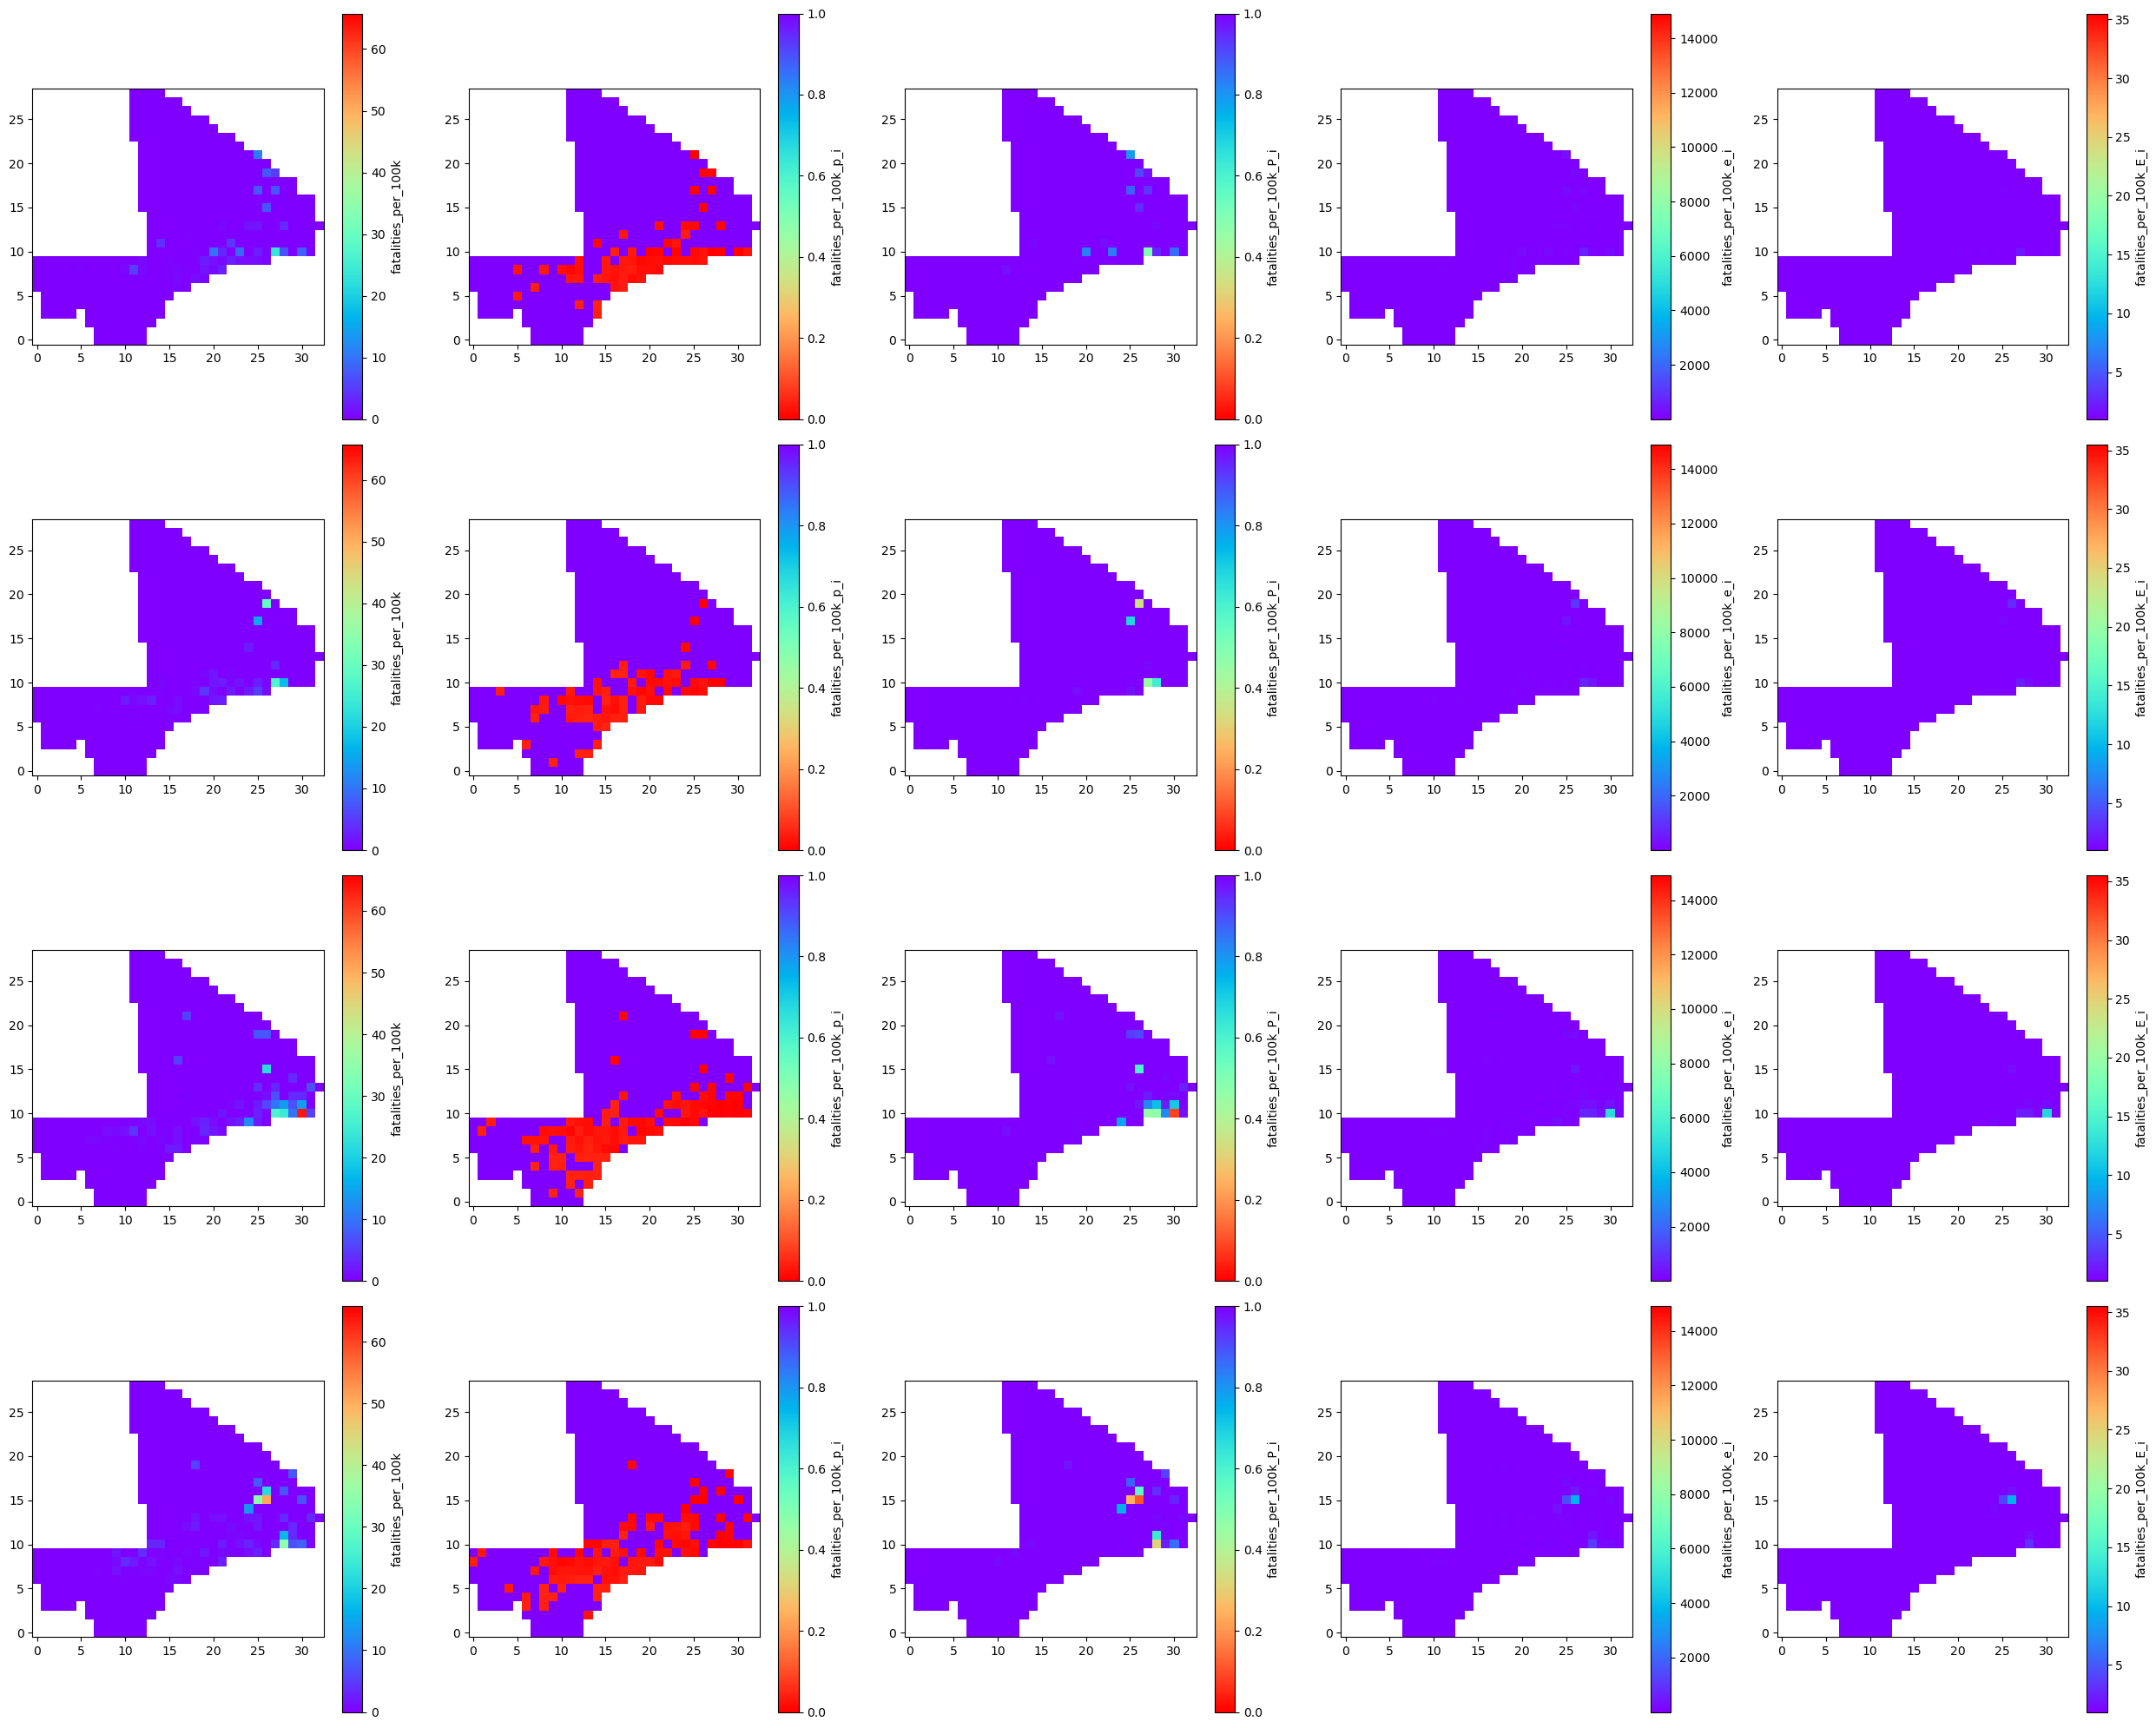

In [16]:
plot_features_grid(new_df_yearly_mali, feature, period_range = np.arange(2020, 2024))

In [17]:
# try with rwanda
country_name = 'Rwanda'
country_id = get_country_id_by_name(country_name)
print(country_id)
country_id = 156

new_df_monthly_rwanda = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, country_id)
new_df_yearly_rwanda = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, country_id)


[(156, 'Rwanda')]


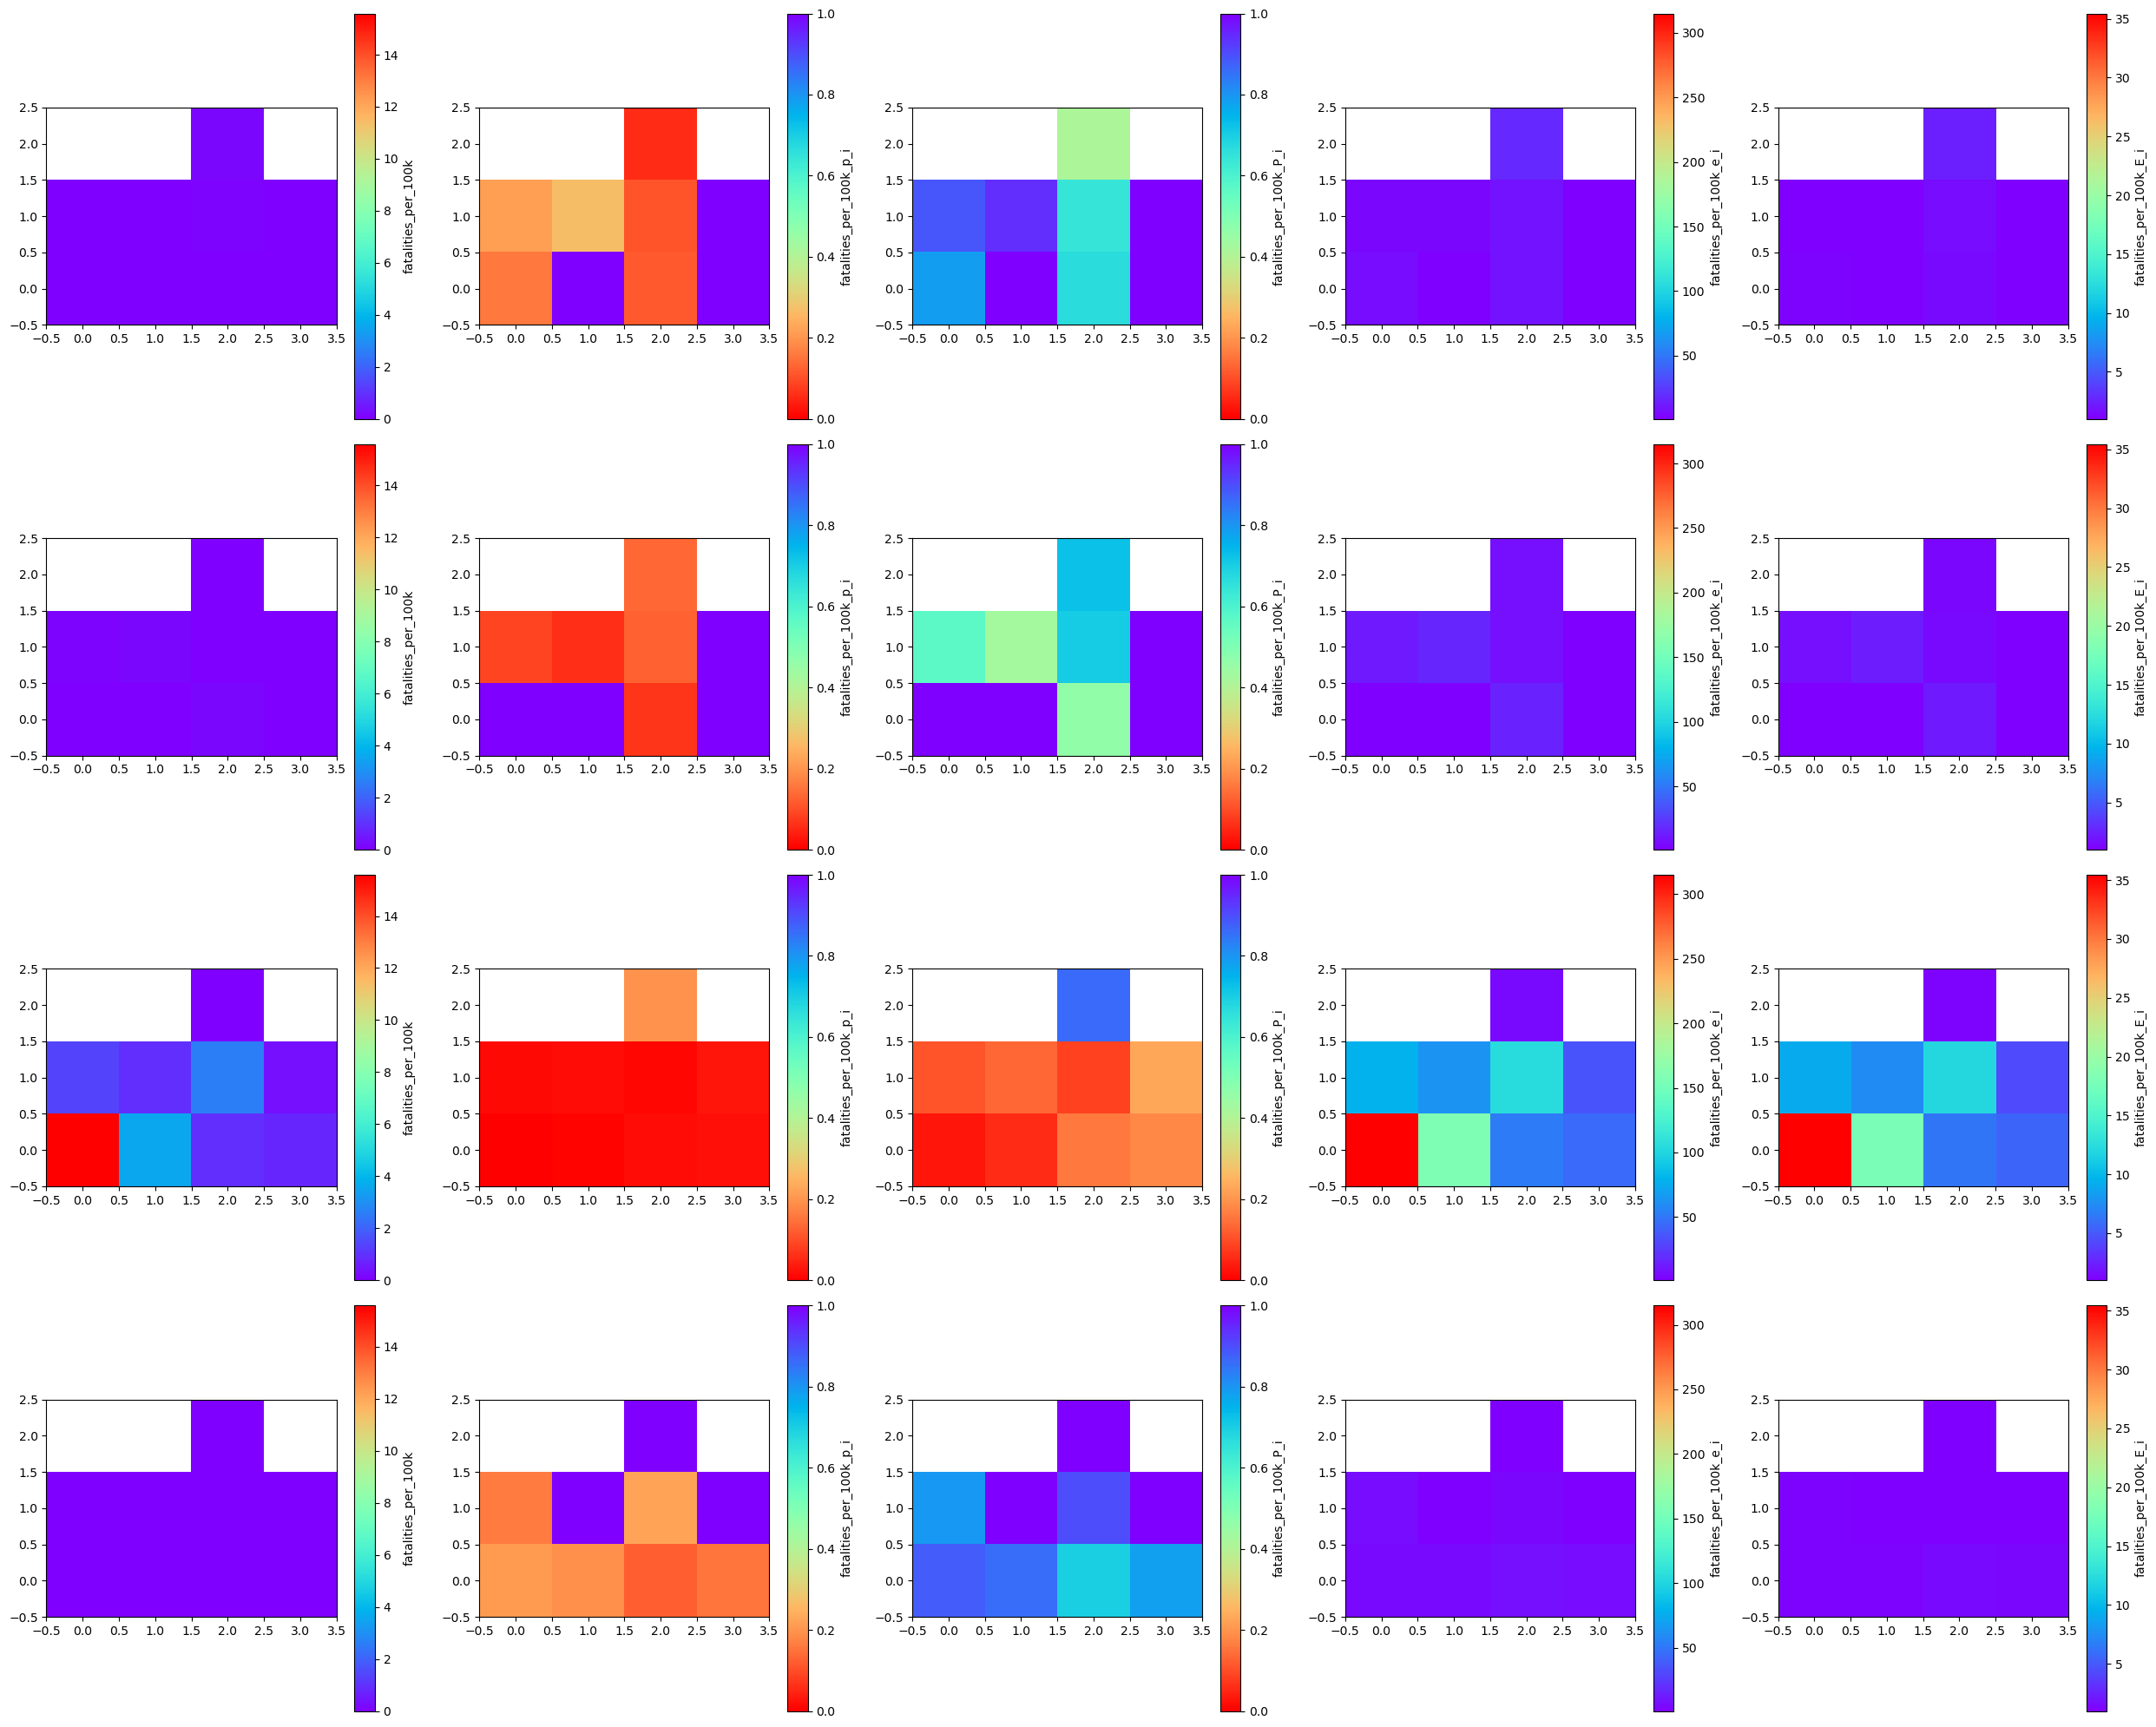

In [19]:
plot_features_grid(new_df_yearly_rwanda, feature, period_range = np.arange(1992, 1996))

172
04.1994


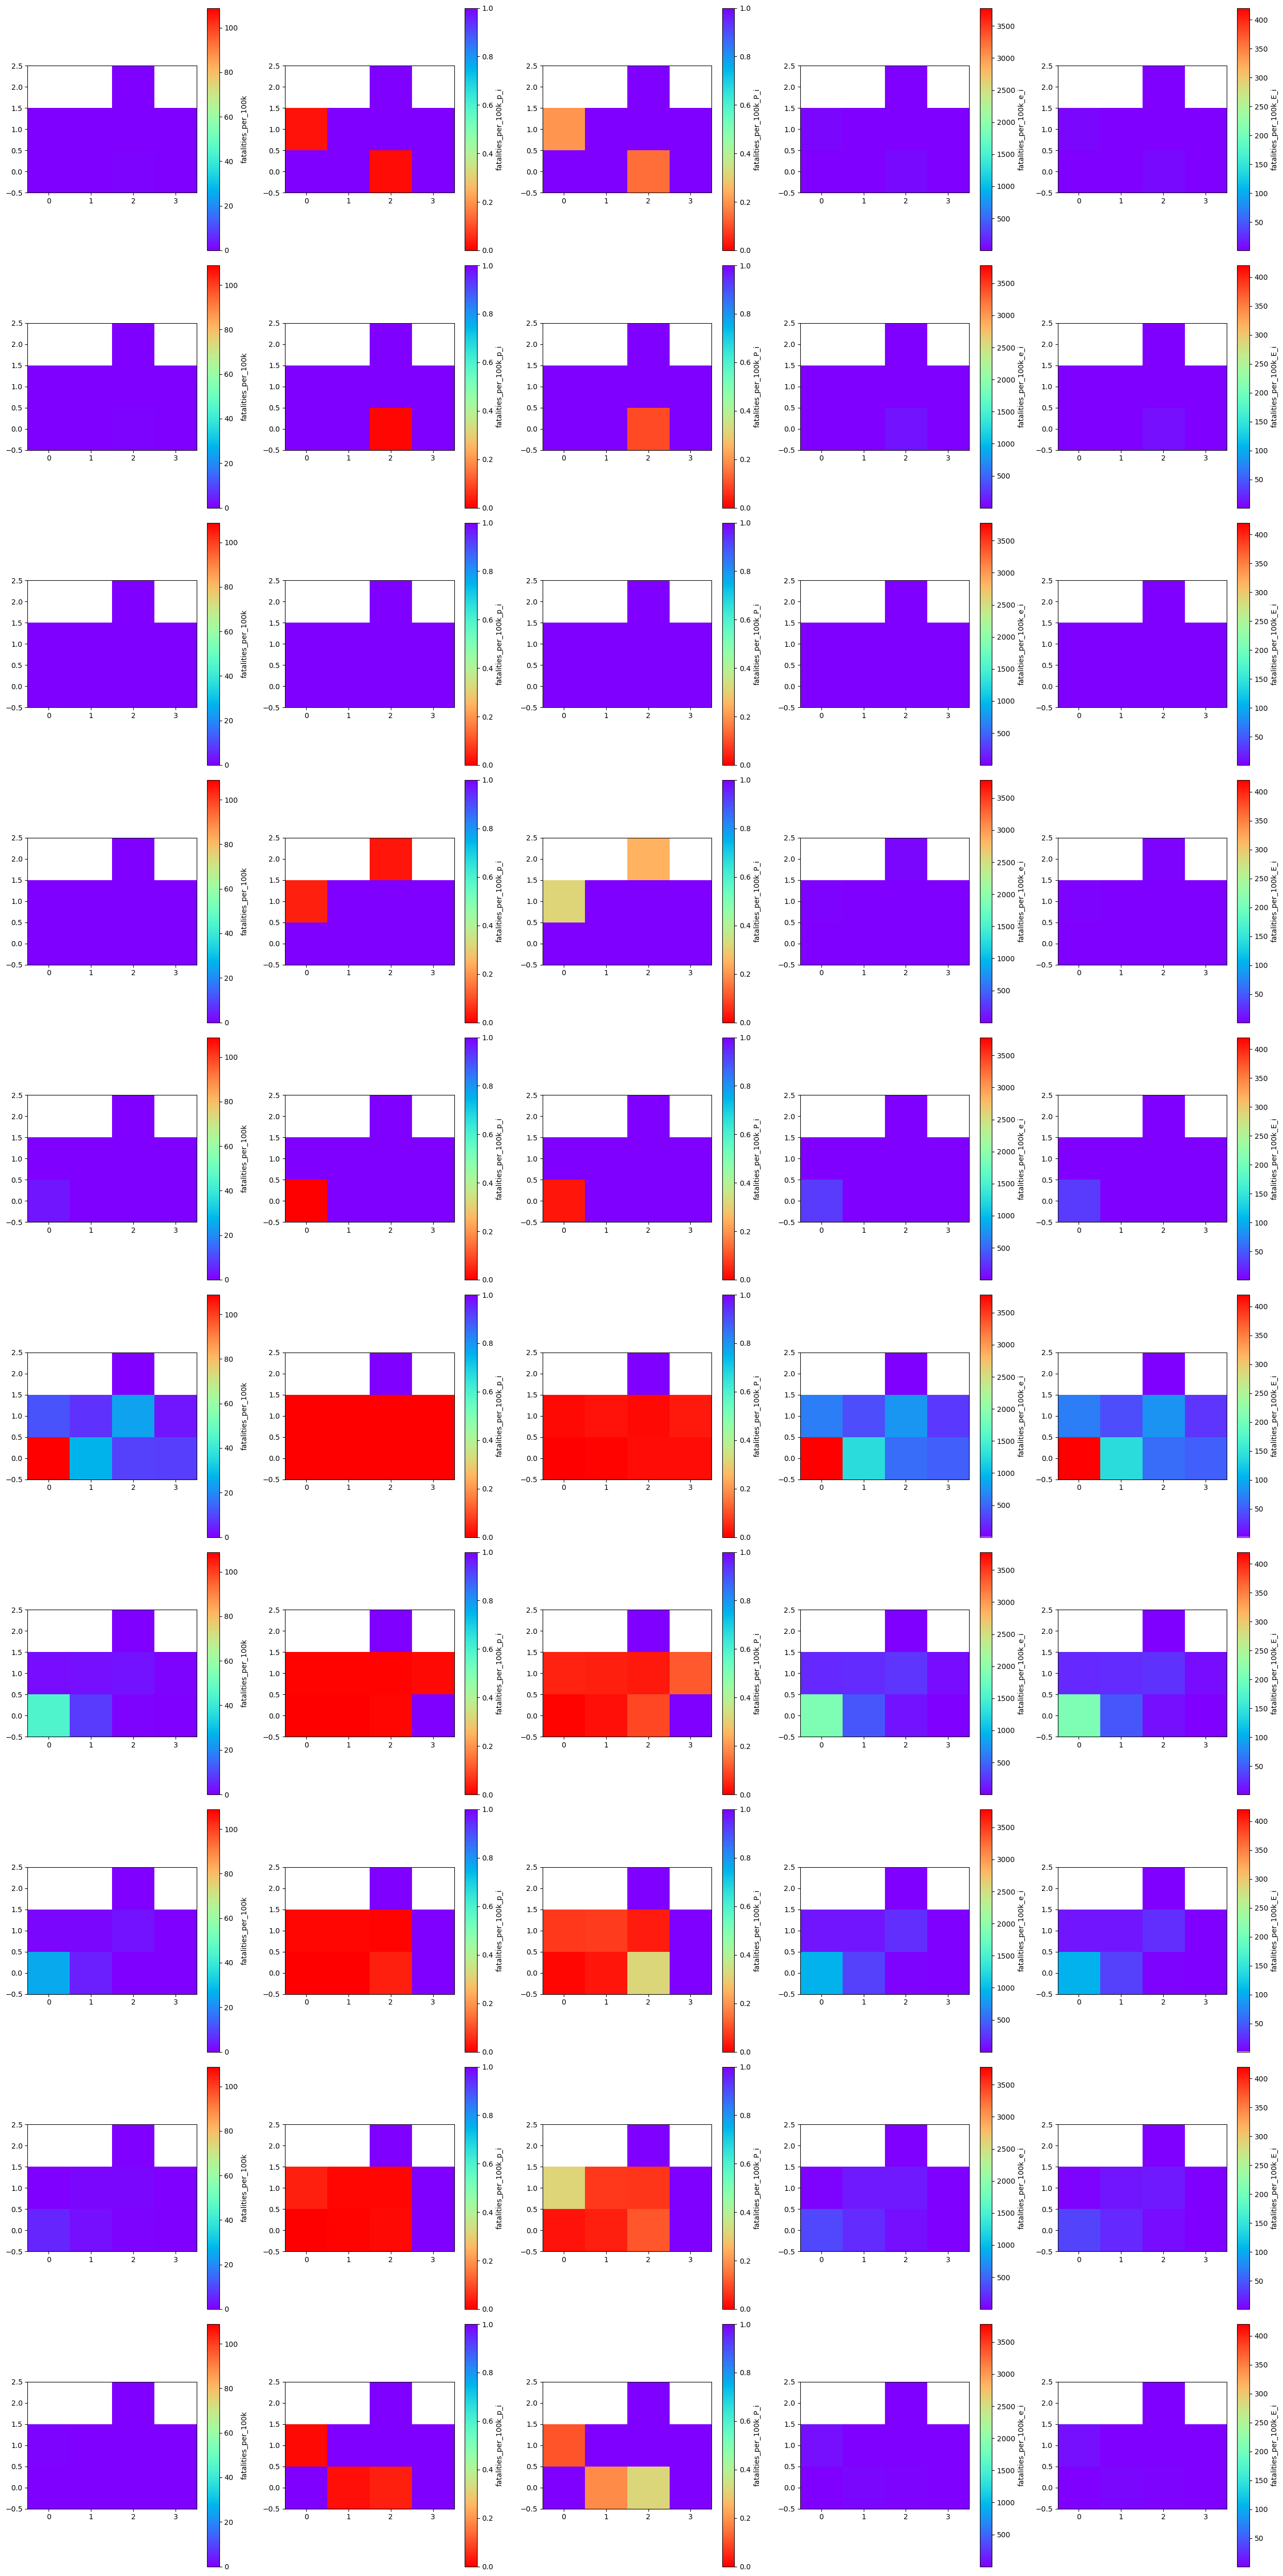

In [34]:
# what months see the highest E_i
high_month = new_df_monthly_rwanda[new_df_monthly_rwanda['fatalities_per_100k_E_i'] == new_df_monthly_rwanda['fatalities_per_100k_E_i'].max()]['month_id'].values[0]
print(high_month)
print(calculate_date_from_index(high_month))

#lest try ranwda with the monthly data
plot_features_grid(new_df_monthly_rwanda, feature, period_range = np.arange(high_month-5, high_month+5))

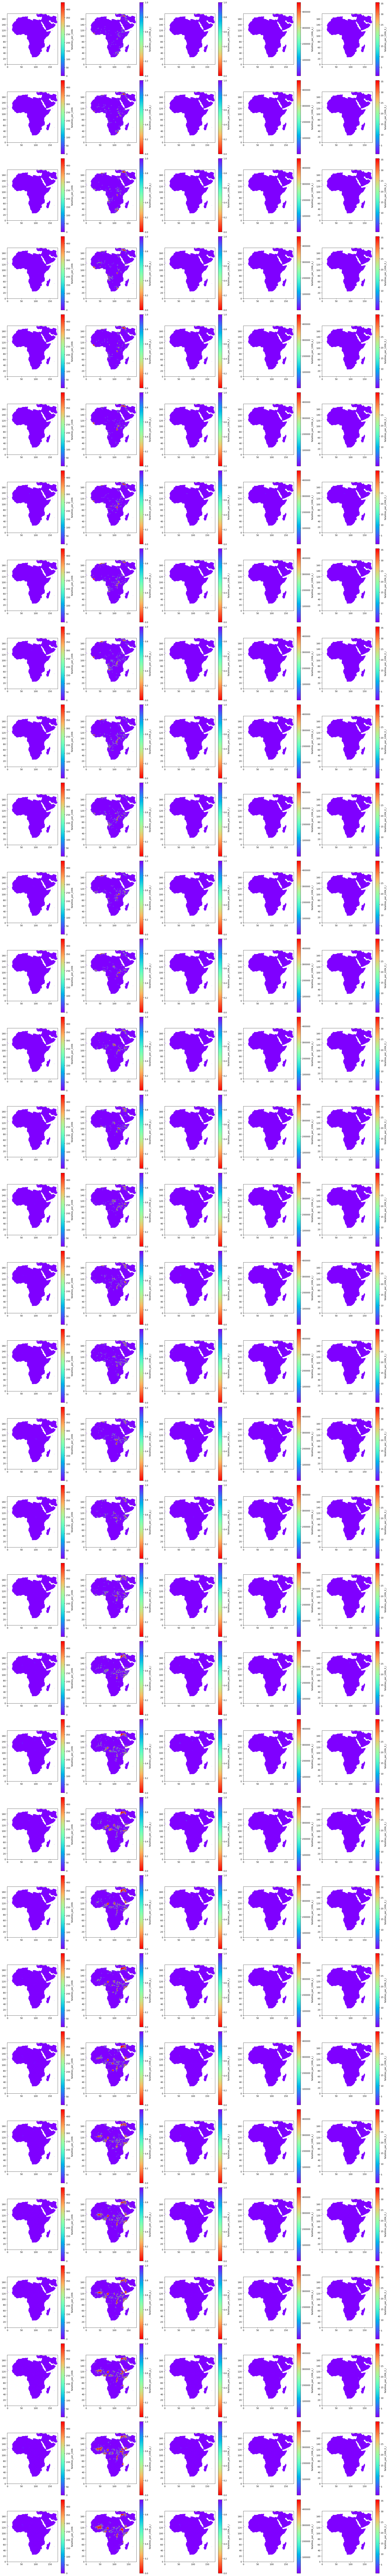

In [22]:
# try "global" yearly 1992-1996
region_id_type = 'global'
region_id = None

new_df_monthly_global = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly_global = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

plot_features_grid(new_df_yearly_global, feature, period_range = np.arange(1991, 2024))

# BETTER NAMING BEFORE ANYTHING ELSE!!!!



In [18]:
return_periods = calculate_return_periods(liklihood, 'cdf', 'likelihood')

NameError: name 'liklihood' is not defined

In [ ]:
return_periods

In [ ]:
liklihood['cdf']

In [ ]:
plt.hist(liklihood, bins=100)
plt.show()

In [ ]:
return_periods = calculate_return_periods(cdf, liklihood, 10000)